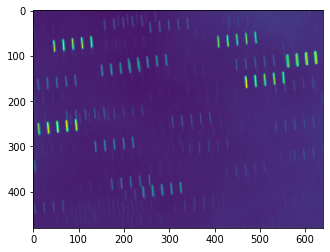

In [327]:
%matplotlib inline

import numpy as np
from skimage.color import rgb2gray
from skimage.feature import *
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform, SimilarityTransform
import matplotlib.pyplot as plt
from skimage import util
from skimage import io
from skimage import exposure
from skimage import morphology
from skimage import measure
from skimage import filters
import json

def read_annotation_file(path):
    '''This creates a dictionary where the first key is the sequence id,
    and the second key is the frame id, which contains a list of the 
    annotation points as lists of floating numbers.
    For example sequence #1 shown above contains 3 objects, which are visible in both frames #1 and #3.'''
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict

seqid = 216
frames = [util.img_as_float(io.imread(f"../spotGEO/train/{seqid}/{i}.png", as_gray=True)) for i in range(1, 6)]
frames = np.array(frames)

plt.imshow(np.max(frames, axis=0), vmin=0, vmax=1)
plt.show()

Detected  1 objects


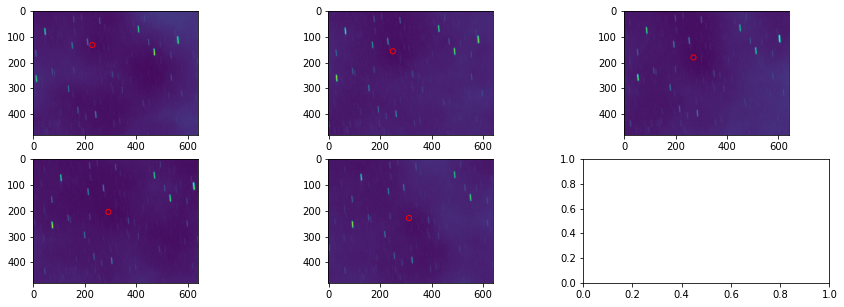

In [328]:
# Get objects coords for seqid

dataset = read_annotation_file('../spotGEO/train_anno.json')

def get_objects(seqid):
    return np.array([dataset[seqid][frame] for frame in dataset[seqid]]).swapaxes(0,1)

def draw_circle(ax, x, y, r):
    circle = plt.Circle((x, y), r, color='r', fill=False)
    ax.add_artist(circle)
    
def draw_target(ax, x, y):
    circle = plt.Circle((x, y), 10, color='r', fill=False)
    ax.add_artist(circle)
    
def draw_prediction(ax, x, y):
    circle = plt.Circle((x, y), 10, color='g', fill=False)
    ax.add_artist(circle)

targets = get_objects(seqid)

print("Detected ", len(targets), "objects")

fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.ravel()

for frameid in range(0,5):
    axs[frameid].imshow(frames[frameid])    
    for target in targets[:,frameid]:
        draw_target(axs[frameid], target[0], target[1])    
plt.show()

In [329]:
from skimage import registration
from skimage import transform

def register(src, dst):
    shifts, _, _ = registration.phase_cross_correlation(dst, src, upsample_factor=100)
    return SimilarityTransform(translation=-np.flip(shifts))

In [330]:
T1 = register(frames[1], frames[0])
T2 = register(frames[2], frames[1])
T3 = register(frames[3], frames[2])
T4 = register(frames[4], frames[3])

In [331]:
# Sometimes the transformation matrix may return outlier transformations
# here we assume the same transformation matrix repeated for all the frames
Q = np.array([T.params.ravel() for T in [T1, T2, T3, T4]])

T = np.median(Q, axis=0).reshape(3,3)

print(T)

[[ 1.     0.    20.575]
 [ 0.     1.    -2.27 ]
 [ 0.     0.     1.   ]]


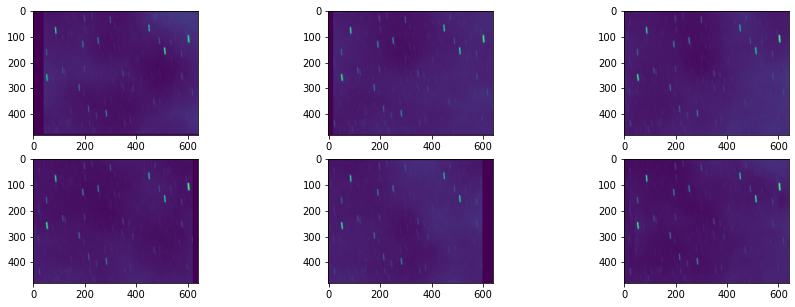

In [332]:
# Transform to frame 2 coords

frame0_2 = transform.warp(frames[0], np.linalg.inv(T) @ np.linalg.inv(T))
frame1_2 = transform.warp(frames[1], np.linalg.inv(T))
frame2_2 = frames[2]
frame3_2 = transform.warp(frames[3], T)
frame4_2 = transform.warp(frames[4], T @ T)

sequence = np.array([frame0_2, frame1_2, frame2_2, frame3_2, frame4_2])

fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.ravel()

for i, frame in enumerate(sequence):
    axs[i].imshow(frame)
    
axs[i+1].imshow(np.max(sequence, axis=0))

plt.show()

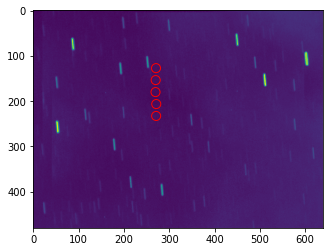

In [333]:
# Transform to frame 2 coords

Ts = [
    T @ T,
    T,
    np.eye(3),
    np.linalg.inv(T),
    np.linalg.inv(T @ T)
]

plt.imshow( np.max(sequence, axis=0) )

for frameid in range(0,5):
    if len(targets) == 0:
        break
    Z = transform.matrix_transform(targets[:,frameid], Ts[frameid])
    for z in Z:        
        draw_target(plt.gcf().gca(), z[0], z[1])
plt.show()

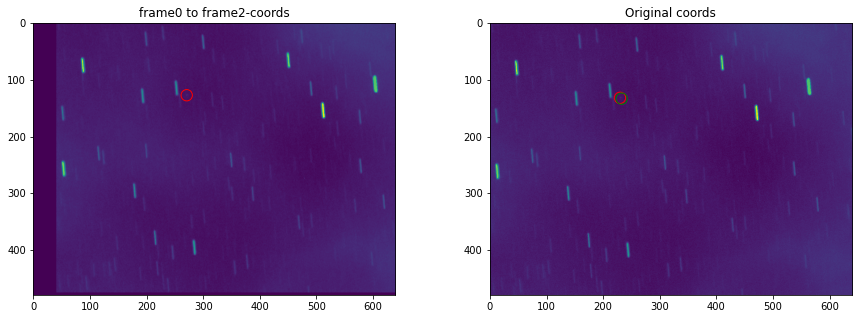

In [334]:
%matplotlib inline

frameid = 0

if len(targets) > 0:
    Z = transform.matrix_transform(targets[:,frameid], Ts[frameid])
else:
    Z = np.array([])

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs = axs.ravel()

axs[0].imshow(sequence[frameid])
axs[0].set_title(f'frame{frameid} to frame2-coords')
for z in Z:
    draw_target(axs[0], z[0], z[1])
    
axs[1].imshow(frames[frameid])
axs[1].set_title('Original coords')
for target in targets[:,frameid]:
    draw_target(axs[1], target[0], target[1])

noise = np.random.normal(size=Z.shape, scale=2.0)

if len(Z) > 0:
    Zo = transform.matrix_transform(Z + noise, np.linalg.inv(Ts[frameid]))
else:
    Zo = np.array([])

for zo in Zo:
    draw_prediction(axs[1], zo[0], zo[1])

plt.show()

Proposal 63


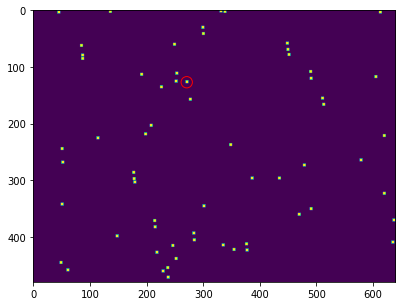

Proposal 56


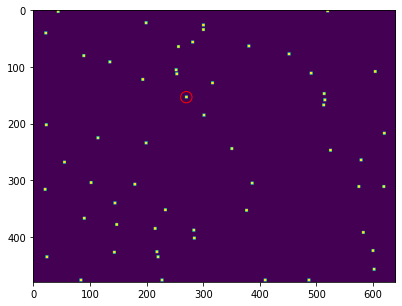

Proposal 113


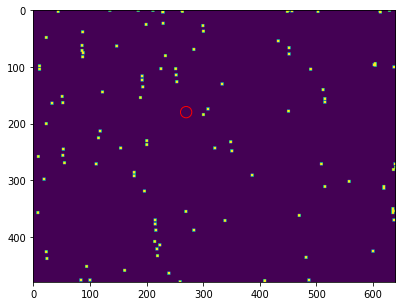

Proposal 66


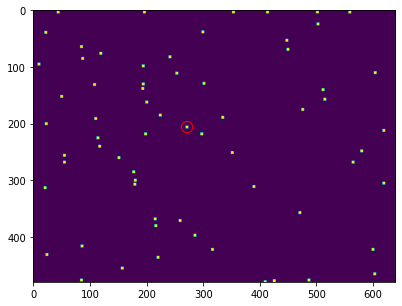

Proposal 49


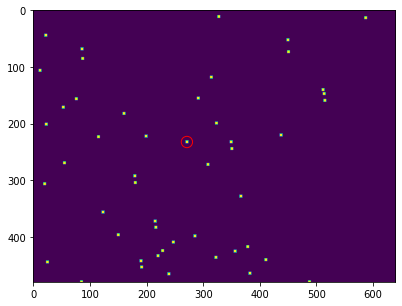

In [362]:
%matplotlib inline

maxima = []
Iproposal = np.zeros_like(frames[0])

for frameid in range(0,5):
    if len(targets) > 0:
        Z = transform.matrix_transform(targets[:,frameid], Ts[frameid])
    else:
        Z = np.array([])

    # Use as Ibase the max of all but frameid frames
    Ibase = np.min(sequence[np.arange(len(sequence)) != frameid], axis=0)

    Idiff = np.maximum(sequence[frameid] - Ibase, 0)*(sequence[frameid] > 0)
    
    Imaxima = morphology.h_maxima(Idiff, 0.02, selem=morphology.diamond(5))
    
    print( 'Proposal', len(np.where(Imaxima)[0]) )

    maxima.append(Imaxima)
    Iproposal += Imaxima
    
    Iout = morphology.dilation(Imaxima, selem=morphology.square(5))    
    
    plt.figure(figsize=(10,5))
    plt.imshow(Iout, vmin=0, vmax=1)
    for z in Z:
        draw_target(plt.gcf().gca(), z[0], z[1])
    plt.show()

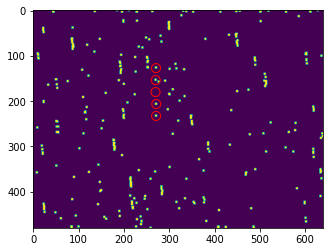

In [363]:
Iout = np.max(maxima, axis=0)

Z = np.array([transform.matrix_transform(targets[:,frameid], Ts[frameid]) for frameid in range(0, 5)])
Z = Z.reshape(-1, 2)

plt.imshow(morphology.dilation(Iout, selem=morphology.square(5)))
for z in Z:
    draw_target(plt.gcf().gca(), z[0], z[1])
plt.show()

uint8
Raw 322 Filtered 155


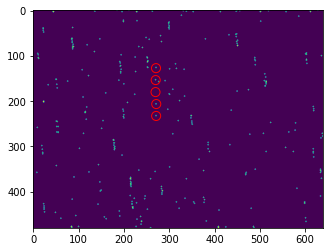

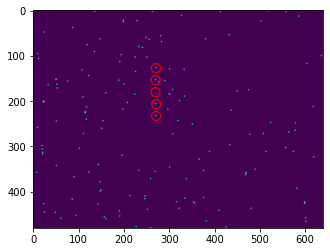

In [389]:
# Remove strikes

# S = morphology.closing(Iout)
print(Iout.dtype)

S = morphology.binary_closing(Iout > 0, selem=morphology.square(15))
S = morphology.remove_small_objects(S, min_size=5)

Ifil = Iout*(~S)

# Ilabel = morphology.label(S)

# plt.imshow(morphology.dilation(S))
# plt.show()

# Ilabel = morphology.label(Iout)

# plt.imshow(color.label2rgb(morphology.dilation(Ilabel, selem=morphology.square(7)), bg_label=0))
# plt.show()

x1, x2 = np.where(Iout > 0)
X = np.c_[x2, x1]

x1, x2 = np.where(Ifil > 0)
Xfil = np.c_[x2, x1]

print('Raw', len(X), 'Filtered', len(Xfil))

plt.imshow(morphology.dilation(Iout))
for z in Z:
    draw_target(plt.gcf().gca(), z[0], z[1])
plt.show()


plt.imshow(morphology.dilation(Ifil))
for z in Z:
    draw_target(plt.gcf().gca(), z[0], z[1])
plt.show()


(480, 640)
Regions (148, 6, 6) coords (148, 2)
[270.85202637 127.05381104]


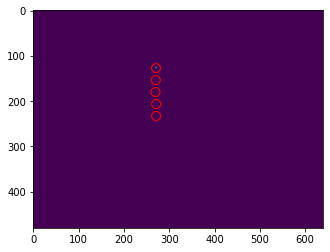

In [391]:
from sklearn import metrics

Iout = np.max(maxima, axis=0)
Iin = np.max(sequence, axis=0)

print(Iin.shape)

# x1, x2 = np.where(Iout > 0)
# X = np.c_[x2, x1]

X = Xfil.copy()

regions = [Iin[r0-3:r0+3, c0-3:c0+3] for c0, r0 in X]
sel = [r.shape[0] == 6 and r.shape[1] == 6 for r in regions]

X = X[sel]
regions = [regions[i] for i, s in enumerate(sel) if s]

regions = np.array(regions)

print('Regions', regions.shape, 'coords', X.shape)

z = Z[np.random.choice(len(Z))]

print(z)

d = np.linalg.norm(X - z, axis=1)
idxs = np.where(d < 10)

i = idxs[0]

Iq = np.zeros(Iout.shape)

Iq[X[i,1], X[i,0]] = 1

plt.imshow(morphology.dilation(Iq))
for z in Z:
        draw_target(plt.gcf().gca(), z[0], z[1])
plt.show()

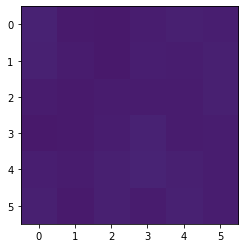

40


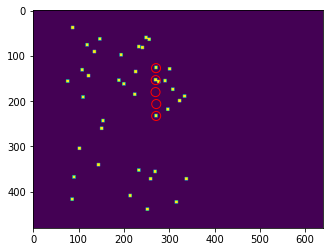

In [392]:
r0, c0 = X[i,1][0], X[i,0][0]

region = Iin[r0-3:r0+3, c0-3:c0+3]

plt.imshow(region, vmin=0, vmax=1)
plt.show()

regions = np.array(regions)

v = regions.reshape(-1, 6*6)
templ = region.reshape(1, 6*6)

d = np.linalg.norm( v - templ, axis=1 )

idxs = np.where(d < 0.08)[0]

Xsel = X[idxs]

Iq = np.zeros(Iin.shape)
Iq[Xsel[:,1], Xsel[:,0]] = 1.0

print( len(Xsel))

plt.imshow(morphology.dilation(Iq, selem=morphology.square(7)))
for z in Z:
        draw_target(plt.gcf().gca(), z[0], z[1])
plt.show()

# for idx in idxs:
#     plt.imshow(regions[idx], vmin=0, vmax=1)
#     plt.show()


(148, 2) (148, 36)


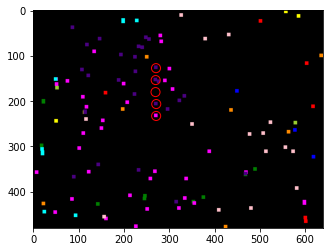

In [393]:
from skimage import color
from sklearn import cluster

D = regions.reshape(-1, 6*6)

labels = cluster.k_means(D, n_clusters=30)[1]

print( X.shape, D.shape )

Iq = np.zeros(Iin.shape)

Iq[X[:,1], X[:,0]] = labels

plt.imshow( color.label2rgb(morphology.dilation(Iq, selem=morphology.square(8)), bg_label=0) )
for z in Z:
        draw_target(plt.gcf().gca(), z[0], z[1])
plt.show()

[(32, 0.9875044675848388)]


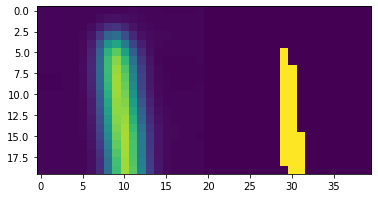

[(21, 0.9792993635163681)]


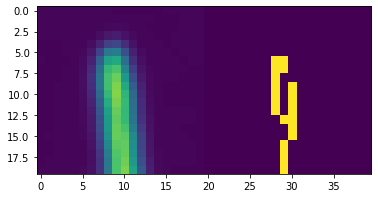

[(34, 0.9965078061200702)]


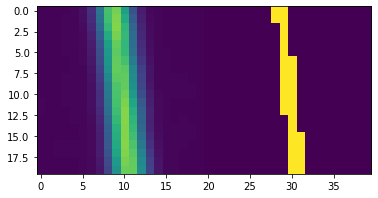

[(53, 0.976976429203085)]


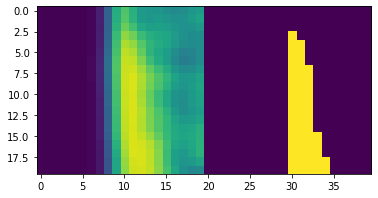

[(29, 0.6445714254773468)]


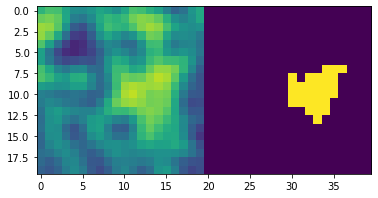

[(53, 0.8921815254637457)]


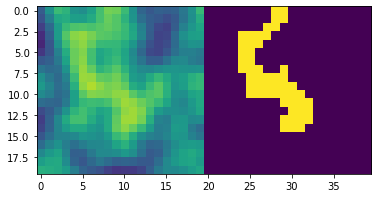

[(80, 0.8602488098101976)]


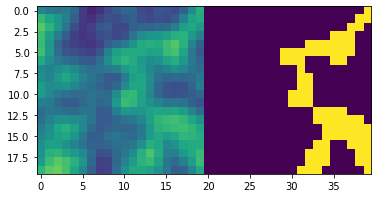

[(11, 0.9842991399404429)]


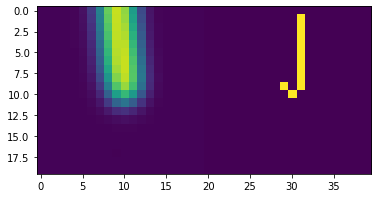

[(37, 0.9846760212500948)]


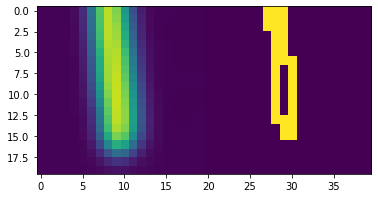

[(9, 0.8770580193070292)]


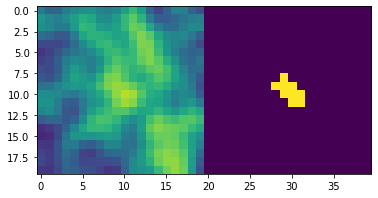

[(24, 0.9797442639364464)]


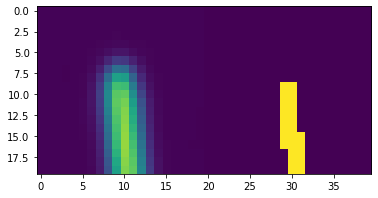

[(79, 0.9810409171378665)]


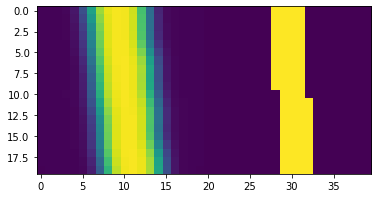

[(33, 0.9901042082155085)]


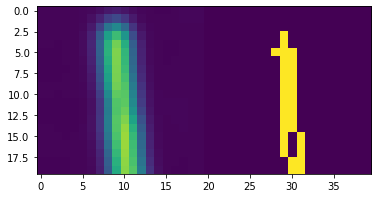

[(36, 0.9889895791680812)]


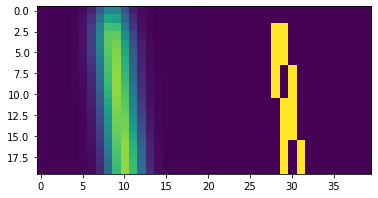

[(31, 0.986744193194769)]


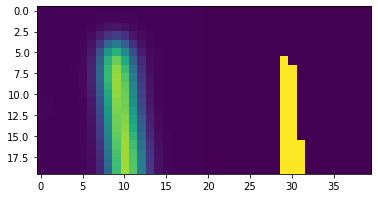

[(27, 0.9909653266417191)]


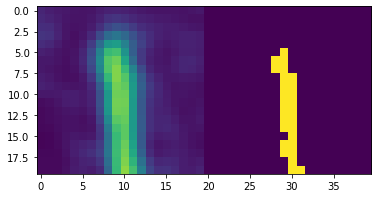

[(5, 1.0)]


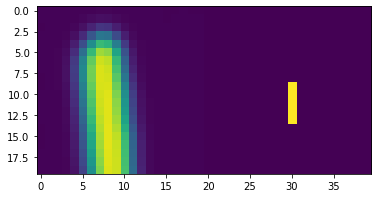

[(3, 0.816496580927726)]


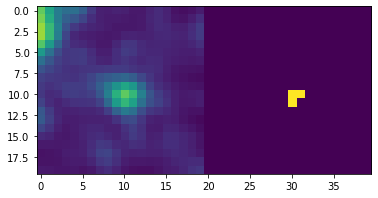

[(6, 1.0)]


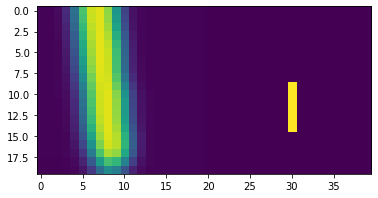

[(3, 0.97372313034591)]


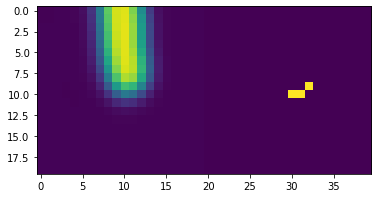

[(33, 0.9952441789728088)]


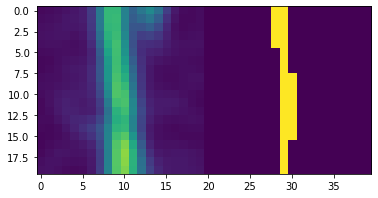

[(42, 0.9861976690636763)]


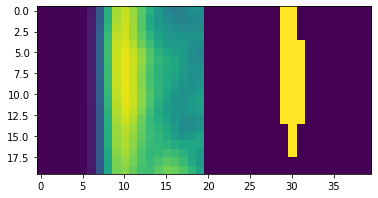

[(26, 0.9904356907894156)]


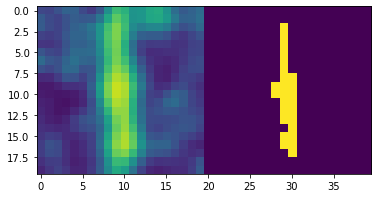

[(31, 0.9892373465027827)]


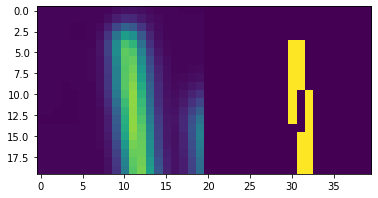

[(16, 0.9197645832749143)]


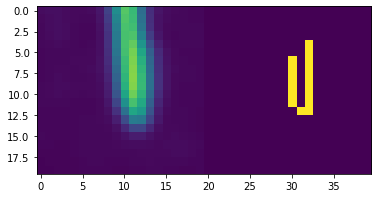

[(37, 0.9946375463188052)]


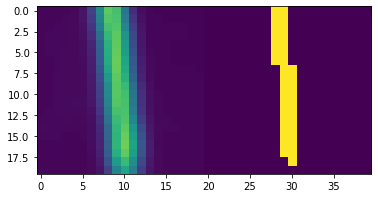

[(83, 0.8643053938699266)]


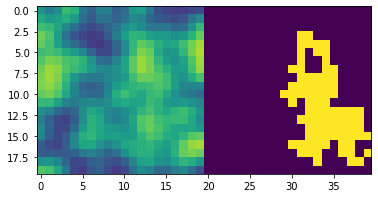

[(4, 0.9486832980505138)]


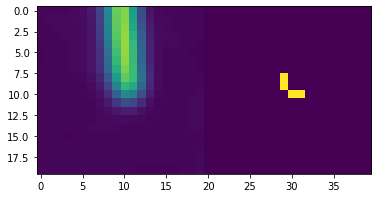

[(23, 0.9369705172900399)]


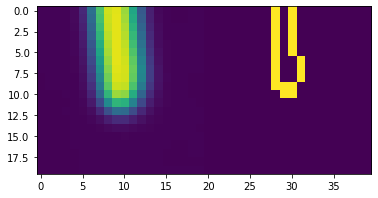

[(6, 0.674199862463242)]


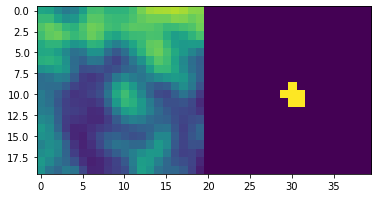

[(7, 1.0)]


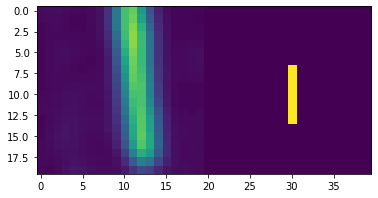

[(2, 1.0)]


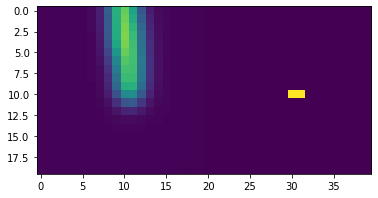

[(190, 0.571683362205168)]


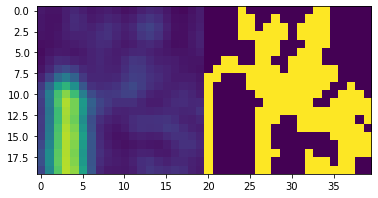

[(20, 0.9963185730827704)]


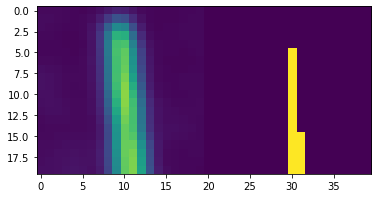

[(70, 0.9654563776374511)]


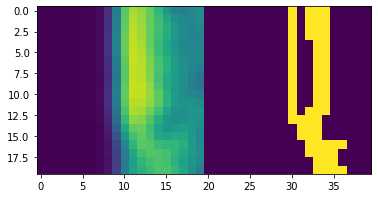

[(23, 0.9780107364738361)]


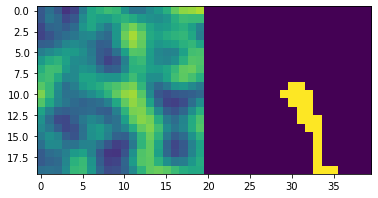

[(111, 0.6894524543324232)]


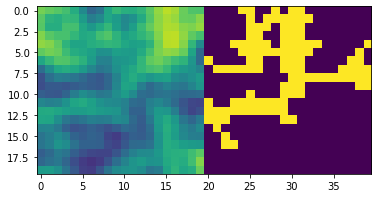

[(54, 0.8782053087275082)]


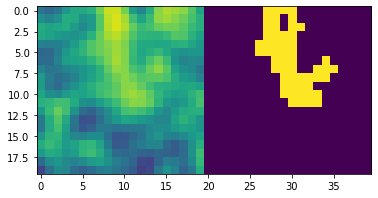

[(6, 0.9252741613028527)]


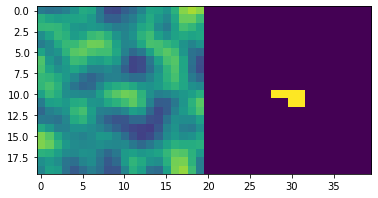

[(3, 1.0)]


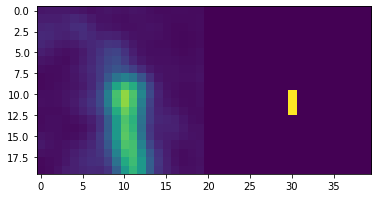

[(28, 0.9908546332667225)]


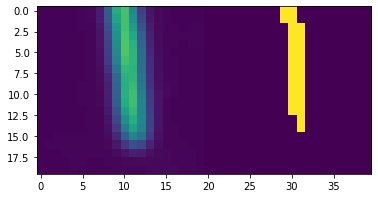

[(26, 0.9870710279033286)]


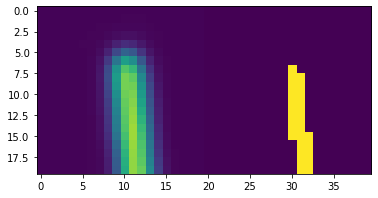

[(4, 0.0)]


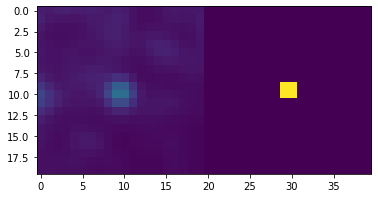

[(30, 0.9872922550385618)]


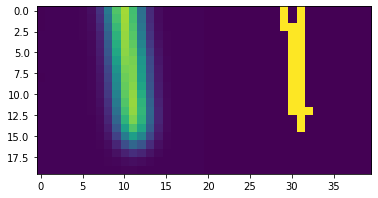

[(19, 0.9323644013939614)]


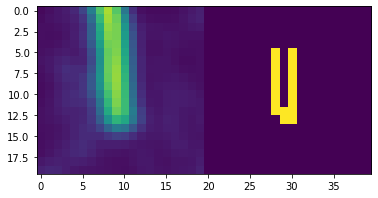

[(22, 0.994447277743491)]


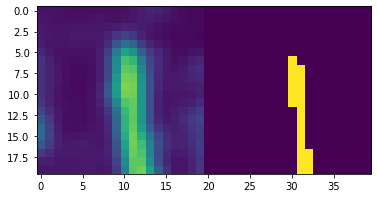

[(49, 0.9860848499986653)]


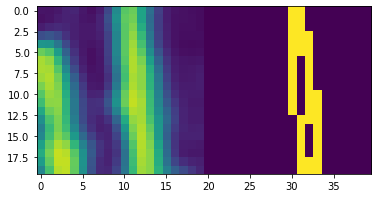

[(41, 0.9949270652954441)]


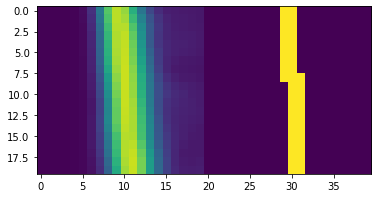

[(32, 0.9965613478226334)]


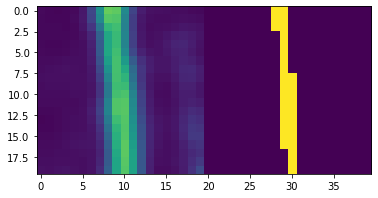

[(21, 0.8108473421079847)]


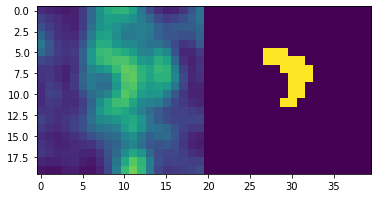

[(99, 0.6941624864491418)]


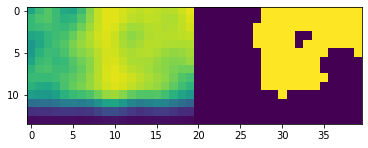

[(203, 0.8597637950066553)]


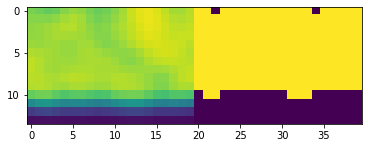

[(176, 0.8633001553784039)]


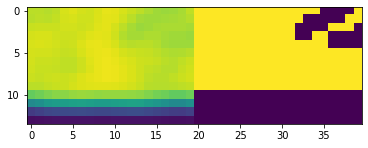

[(38, 0.9296770648866552)]


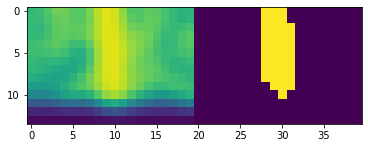

In [340]:
frameid = 1

Imaxima = maxima[frameid]

x1, x2 = np.where(Imaxima)
X = np.int32(np.c_[x1, x2])

Iin = sequence[frameid]


def feature_of_region_area(Iregion):
    if Iregion.shape[0] == 0 or Iregion.shape[1] == 0:
        return 0
    thr = filters.threshold_otsu(Iregion)
    regions = morphology.label(Iregion > thr)
    regions = measure.regionprops(regions)
    if len(regions) > 0:
        return np.max([region.area for region in regions])
    else:
        return 0
# skimage.segmentation.flood(image, seed_point

from skimage import segmentation
    
def feature_region(Iregion):
    if Iregion.shape[0] == 0 or Iregion.shape[1] == 0:
        return (np.inf, 1)
    
    Ires = exposure.rescale_intensity(Iregion)
    Ires = exposure.adjust_sigmoid(Ires)
    Ires = filters.gaussian(Ires)
    
    Imask = segmentation.flood(Ires, (Ires.shape[0]//2, Ires.shape[1]//2), tolerance=0.1)
    regions = measure.regionprops(morphology.label(Imask))
    
    return regions[0].area, regions[0].eccentricity
    
# areas = [feature_of_region_area(Iin[r0-10:r0+10, c0-10:c0+10]) for r0, c0 in X]
# ecc = [feature_region(Iin[r0-10:r0+10, c0-10:c0+10]) for r0, c0 in X]

# idxs = [idx for idx, e in enumerate(ecc) if not (e > 0.95 and e < 0.99)  ]

from skimage import feature

for i, (r0, c0) in enumerate(X):
    Iregion = Iin[r0-10:r0+10, c0-10:c0+10]
    
    if (Iregion.shape[0] == 0) or (Iregion.shape[1] == 0):
        continue
    
    Ires = exposure.rescale_intensity(Iregion)
    Ires = exposure.adjust_sigmoid(Ires)
    Ires = filters.gaussian(Ires)
    
    Imask = segmentation.flood(Ires, (Ires.shape[0]//2, Ires.shape[1]//2), tolerance=0.1)
    regions = measure.regionprops(morphology.label(Imask))
    
    print([(region.area, region.eccentricity) for region in regions])
    
    plt.imshow(np.hstack([Ires, Imask]))
    plt.show()

    
# for idx in idxs:
#    r0, c0 = X[idx]
#    Iregion = Iin[r0-10:r0+10, c0-10:c0+10]
    
#    thr = filters.threshold_otsu(Iregion)
#    Imask =Iregion > thr
    
#    print(areas[idx], eccentr[idx])
    
#    plt.imshow(np.hstack([Iregion, Imask]))
#    plt.show()
    

Xsel = X[idxs]

plt.imshow(morphology.dilation(Imaxima))
plt.show()

Imaxima_sel = np.zeros_like(Imaxima)
Imaxima_sel[Xsel[:,0], Xsel[:,1]] = 1

plt.imshow(morphology.dilation(Imaxima_sel))
plt.show()

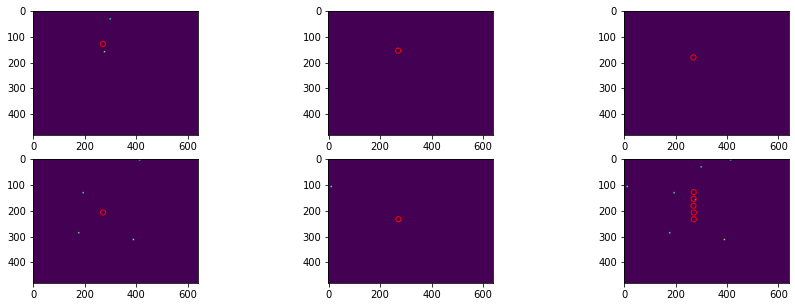

In [394]:
def extract_proposal(frameid):
    Imaxima = maxima[frameid]

    x1, x2 = np.where(Imaxima)
    X = np.int32(np.c_[x1, x2])

    Iin = sequence[frameid]

    r = 3
    feats = [feature_region(Iin[r0-r:r0+r, c0-r:c0+r]) for r0, c0 in X]
    
    idxs = [idx for idx, feat in enumerate(feats) if feat[0] < 50 and feat[1] < 0.95 ]
    
    idxs = np.random.random(size=len(X)) < 0.02
    
    Xsel = X[idxs]
    
    Imaxima_sel = np.zeros_like(Imaxima)
    Imaxima_sel[Xsel[:,0], Xsel[:,1]] = 1
    
    return Imaxima_sel

Iout = np.array([extract_proposal(i) for i in range(0, 5)])

fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.ravel()

for i, I in enumerate(Iout):
    axs[i].imshow(morphology.dilation(I,selem=morphology.square(5)))
Iproposal = np.max(Iout, axis=0)
axs[i+1].imshow(morphology.dilation(Iproposal, selem=morphology.square(5)))

for frameid in range(0,5):
    if len(targets) > 0:
        Z = transform.matrix_transform(targets[:,frameid], Ts[frameid])
    else:
        Z = np.array([])
    for z in Z:
        draw_target(axs[frameid], z[0], z[1])
        draw_target(axs[5], z[0], z[1])
plt.show()

X input (58, 2)
X output (22, 2)
X input (54, 2)
X output (26, 2)
X input (98, 2)
X output (45, 2)
X input (60, 2)
X output (23, 2)
X input (49, 2)
X output (26, 2)


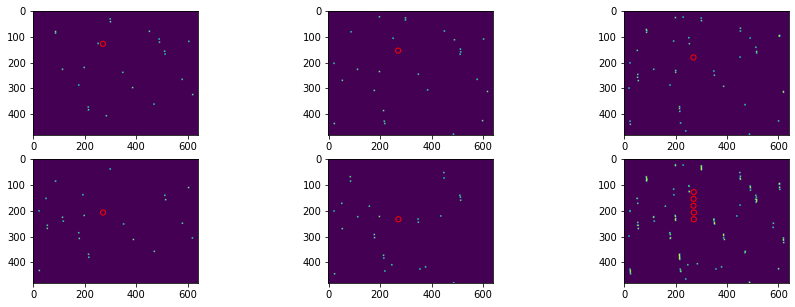

In [342]:
# Use Base classifier

import pickle

clf = pickle.load(open('../classifier.pkl', 'rb'))

def extract_proposal(frameid):
    Imaxima = maxima[frameid]

    x1, x2 = np.where(Imaxima)
    X = np.int32(np.c_[x1, x2])
    
    Iin = sequence[frameid]
    r = 5
    
    regions = [Iin[r0-r:r0+r, c0-r:c0+r] for r0, c0 in X]
    
    # Remove empty invalid regions
    idxs = [region.shape[0] > 0 and region.shape[1] > 0 for region in regions]
    
    X = X[idxs]
    regions = [regions[i] for i in range(len(idxs)) if idxs[i]]
    
    print('X input', X.shape)
    
    regions = [transform.resize(region, (7, 7)).ravel() for region in regions]
    idxs = clf.predict(regions) > 0
    
    Xsel = X[idxs]
    
    print('X output', Xsel.shape)
    
    Imaxima_sel = np.zeros_like(Imaxima)
    Imaxima_sel[Xsel[:,0], Xsel[:,1]] = 1
    
    return Imaxima_sel


Iout = np.array([extract_proposal(i) for i in range(0, 5)])

fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.ravel()

for i, I in enumerate(Iout):
    axs[i].imshow(morphology.dilation(I,selem=morphology.square(5)))
Iproposal = np.max(Iout, axis=0)
axs[i+1].imshow(morphology.dilation(Iproposal, selem=morphology.square(5)))

for frameid in range(0,5):
    if len(targets) > 0:
        Z = transform.matrix_transform(targets[:,frameid], Ts[frameid])
    else:
        Z = np.array([])
    for z in Z:
        draw_target(axs[frameid], z[0], z[1])
        draw_target(axs[5], z[0], z[1])
plt.show()

In [343]:
# Append frameid to proposal coords

def extract_proposal(Iin, X, frameid):
    feats = [feature_region(Iin[r0-10:r0+10, c0-10:c0+10]) for r0, c0 in X]
    idxs = [idx for idx, feat in enumerate(feats) if feat[0] < 50 and feat[1] < 0.95 ]
    labels = np.zeros(len(X))
    labels[idxs] = 1    
    return labels


X = np.array([ np.c_[np.where(Imax)] for Imax in maxima])
frameidxs = [np.repeat(i, len(x)) for i, x in enumerate(X)]
labels = [extract_proposal(sequence[i], x, i) for i, x in enumerate(X)]

X = np.c_[np.concatenate(frameidxs), np.concatenate(X), np.concatenate(labels)]

print('X input', X.shape)

Xsel = X[X[:,-1]>0,:-1]

print('X output', Xsel.shape)



X input (347, 4)
X output (81, 3)


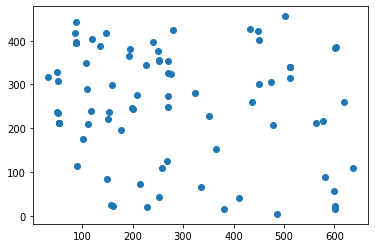

In [344]:
plt.scatter(Xsel[:,2], 480-Xsel[:,1])
plt.show()

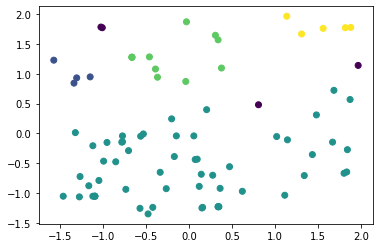

(77, 4)


In [345]:
from sklearn import cluster
from sklearn.preprocessing import StandardScaler

X_tr = StandardScaler().fit_transform(Xsel[:,[1,2]])

_, labels = cluster.dbscan(X_tr, min_samples=3)
labels += 1 # number of objects is offset by 1

plt.scatter(X_tr[:, 0], X_tr[:,1], c=labels)
plt.show()

objs = np.c_[Xsel, labels][labels > 0]

print(objs.shape)

Found  4 objects


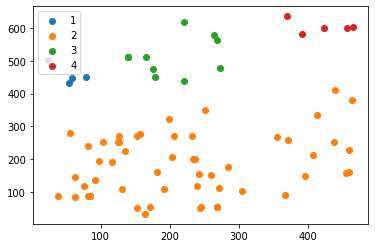

In [346]:
nobjects = int(objs[:,-1].max())
print('Found ', nobjects, 'objects')

for n in range(nobjects):
    coords = objs[(objs[:,-1] == (n+1)), :-1]
    plt.scatter(coords[:,1], coords[:,2], label=f"{n+1}")
plt.legend()
plt.show()

[[  0.  58. 448.]
 [  0.  78. 451.]
 [  2.  54. 432.]
 [  3.  24. 502.]]
274.8425925925924 275.43518518518516 279.1152445369405 52557.68396826502


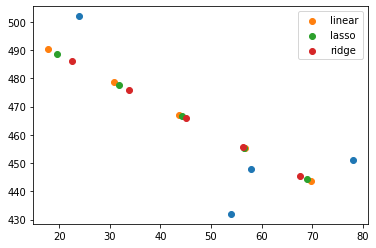

In [347]:
# Interpolate
from sklearn.linear_model import LinearRegression

objid = 1
coords = objs[(objs[:,-1] == 1), :-1]

print(coords)

lr_x = LinearRegression().fit(coords[:,0].reshape(-1,1), coords[:,1])
lr_y = LinearRegression().fit(coords[:,0].reshape(-1,1), coords[:,2])

t = np.arange(0, 5).reshape(-1, 1)

x_pred = lr_x.predict(t)
y_pred = lr_y.predict(t)

# x_pred = np.random.uniform(370, 460, size=x_pred.shape)
# y_pred = np.random.uniform(370, 460, size=y_pred.shape)

from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics

lr = LinearRegression().fit(coords[:,0].reshape(-1, 1), coords[:, [1, 2]])
lasso = Lasso().fit(coords[:,0].reshape(-1, 1), coords[:, [1, 2]])
ridge = Ridge().fit(coords[:,0].reshape(-1, 1), coords[:, [1, 2]])

v_pred = lr.predict(t)
lasso_pred = lasso.predict(t)
ridge_pred = ridge.predict(t)

# metrics.mean_squared_error

lr_score = metrics.mean_squared_error(coords[:,[1,2]], lr.predict(coords[:,0].reshape(-1, 1)))
lasso_score = metrics.mean_squared_error(coords[:,[1,2]], lasso.predict(coords[:,0].reshape(-1, 1)))
ridge_score = metrics.mean_squared_error(coords[:,[1,2]], ridge.predict(coords[:,0].reshape(-1, 1)))

score = metrics.mean_squared_error(coords[:,[1,2]], np.random.uniform(270, 350, size=coords[:,[1,2]].shape))

print(lr_score, lasso_score, ridge_score, score)

plt.scatter(coords[:,1], coords[:,2])
plt.scatter(v_pred[:,0], v_pred[:,1], label='linear')
plt.scatter(lasso_pred[:,0], lasso_pred[:,1], label='lasso')
plt.scatter(ridge_pred[:,0], ridge_pred[:,1], label='ridge')

plt.legend()
plt.show()

In [348]:
c_coords = []

for i in range(0, 5):
    c_frame = coords[(coords[:,0]).astype('int') == i]
    if len(c_frame) == 0:
        v = lr.predict([[i]])[0]
        c_coords.append(v)
    elif len(c_frame) > 1:
        v0 = lr.predict([[i]])[0]
        d = np.linalg.norm(c_frame[:,[1, 2]] - v0)
        idx = np.argmin(d)
        v = c_frame[idx,[1,2]]
        c_coords.append(v)
    else:
        c_coords.append(c_frame[0,[1,2]])
    
c_coords = np.array(c_coords)

print(c_coords)
print(v_pred)

[[ 58.         448.        ]
 [ 56.74074074 455.33333333]
 [ 54.         432.        ]
 [ 24.         502.        ]
 [ 17.85185185 490.33333333]]
[[ 69.7037037  443.66666667]
 [ 56.74074074 455.33333333]
 [ 43.77777778 467.        ]
 [ 30.81481481 478.66666667]
 [ 17.85185185 490.33333333]]


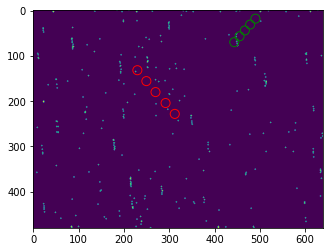

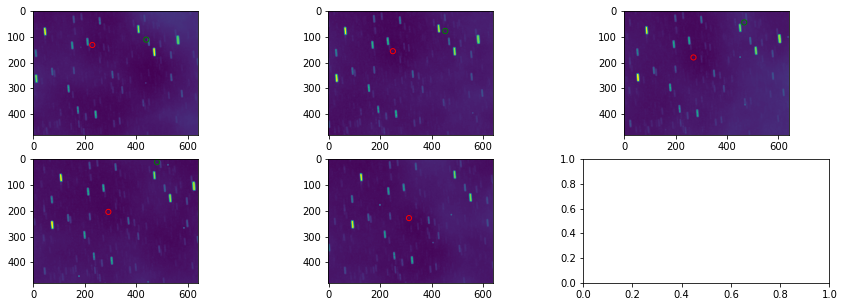

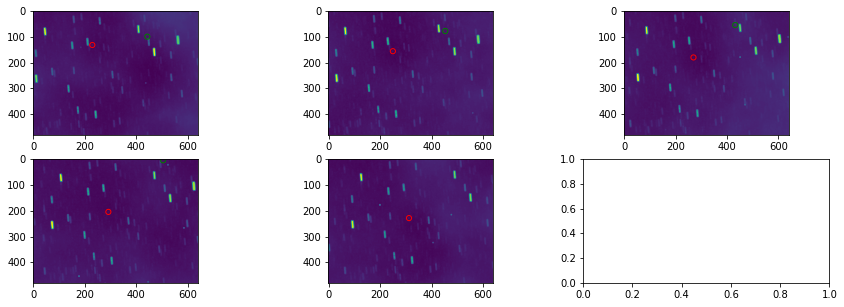

In [349]:
axs = plt.gcf().gca()

plt.imshow(morphology.dilation(np.max(maxima, axis=0)))

for frameid in range(0,5):    
    vi_pred = v_pred[frameid]
    x_pred, y_pred = vi_pred[1], vi_pred[0]
    
    for target in targets[:,frameid]:
        draw_target(axs, target[0], target[1])
        draw_prediction(axs, x_pred, y_pred)
plt.show()


fig, axs = plt.subplots(2, 3, figsize=(15, 5))
axs = axs.ravel()

for frameid in range(0,5):
    vi_pred = transform.matrix_transform(v_pred[frameid], Ts[frameid])
    x_pred, y_pred = vi_pred[0,1], vi_pred[0,0]
    
    axs[frameid].imshow(morphology.dilation(frames[frameid], selem=morphology.square(5)))
    
    for target in targets[:,frameid]:
        draw_target(axs[frameid], target[0], target[1])
        draw_prediction(axs[frameid], x_pred, y_pred)
plt.show()

# Interpoleted coords

fig, axs = plt.subplots(2, 3, figsize=(15, 5))
axs = axs.ravel()

for frameid in range(0,5):
    vi_pred = transform.matrix_transform(c_coords[frameid], Ts[frameid])
    x_pred, y_pred = vi_pred[0,1], vi_pred[0,0]
    
    axs[frameid].imshow(morphology.dilation(frames[frameid], selem=morphology.square(5)))
    
    for target in targets[:,frameid]:
        draw_target(axs[frameid], target[0], target[1])
        draw_prediction(axs[frameid], x_pred, y_pred)
plt.show()

Proposal 156


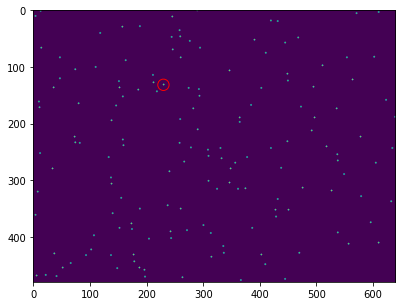

Proposal 195


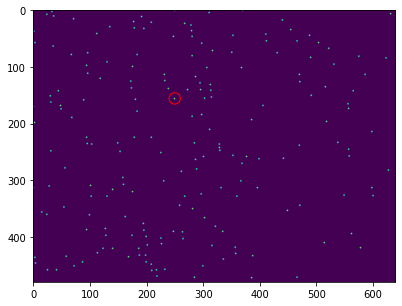

Proposal 164


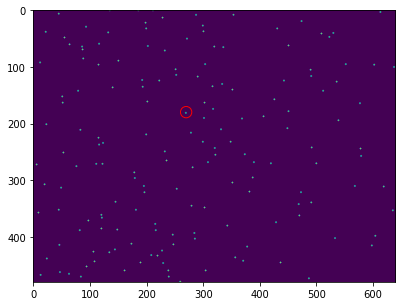

Proposal 183


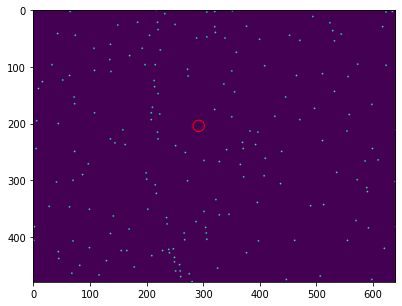

Proposal 142


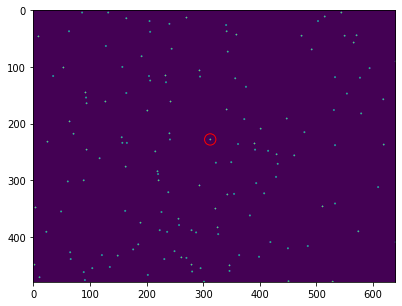

In [350]:
# Maybe similar result if we use frames directly without transformation?
maxima = []

for frameid in range(0,5):
    Ibase1 = np.mean(frames[np.arange(len(frames)) != frameid], axis=0)
    
    Idiff = (frames[frameid] - Ibase1)
    Imaxima = morphology.h_maxima(Idiff, 0.02, selem=morphology.diamond(5))
    maxima.append(Imaxima)
    
    Iout = morphology.dilation(Imaxima)
    
    print( 'Proposal', len(np.where(Imaxima)[0]) )
    
    plt.figure(figsize=(10,5))
    plt.imshow(Iout, vmin=0, vmax=1)
    
    for target in targets[:,frameid]:
        draw_target(plt.gcf().gca(), target[0], target[1])
        
    plt.show()

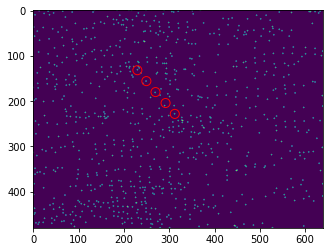

In [351]:
Iout = np.max(maxima, axis=0)

plt.imshow(morphology.dilation(Iout))
for frameid in range(0, 5):
    for target in targets[:,frameid]:
        draw_target(plt.gcf().gca(), target[0], target[1])